In [1]:
import sys, os
import numpy as np
import cv2
import time

### Load original video

In [2]:

cap = cv2.VideoCapture('/beegfs/ua349/mlb/GOPR0095 - pitch 11.mp4')
_, frame = cap.read()
frames = []
while frame is not None:
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    _, frame = cap.read()
assert len(frames) > 0
print('Read frames %d' % len(frames))

Read frames 273


### Load raw heatmaps

In [3]:
folders = os.listdir('../opp/converted/baseline')
framefunc = lambda name: int(name.split('.npy')[0])
folders = sorted(folders, key=framefunc)
print(folders[0], folders[-1])

0.npy 272.npy


### Load openpose joints

In [4]:
sys.path.append('../pproc')
import formats 
joints = formats.cmu_format('../opp/dump.json')
assert len(joints) > 0
assert len(joints) == len(frames)

In [5]:
REF = 188
ANKLE = 13 # 10

In [6]:
def draw_joint(point, img):
    cv2.circle(img, (int(point[0]), int(point[1])), 10, (0, 0, 255), 2)

In [7]:
canvas = frames[REF].copy()
for point in joints[REF]:
    draw_joint(point, canvas)

### Reference frame

Tracking proceeds given reference positions. In this case, we pick a frame whose current joint coords will serve as the reference pos.

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))
plt.imshow(canvas)
plt.show()

In [74]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

def inspect_region(fii, scan_center, heatmap, img, scan_size=100, figsize=(14, 5), plot=True):
    heatmap = cv2.resize(heatmap, (0,0), fx=img.shape[1]/heatmap.shape[1], fy=img.shape[0]/heatmap.shape[0])

    sx, sy = int(scan_center[0]), int(scan_center[1])
    half = int(scan_size/2)
    img_region = img[sy-half:sy+half, sx-half:sx+half]
    h_region = heatmap[sy-half:sy+half, sx-half:sx+half]
    
#     image_max = ndi.maximum_filter(h_maxim, size=20, mode='constant')
    coordinates = peak_local_max(h_region, min_distance=20)
    
    if plot:
        plt.figure(figsize=figsize)
        plt.subplot(1, 4, 1)
        plt.gca().set_title('Frame %d' % fii)
        plt.imshow(img_region)
        plt.subplot(1, 4, 2)
        plt.gca().set_title('Max %.2f' % np.max(h_region))
        plt.imshow(h_region)
        
    
    if len(coordinates) == 0:
        plt.show()
        return None

    maxX, maxY = coordinates[0, 1], coordinates[0, 0]
    h_maxim = np.zeros(h_region.shape, dtype=np.uint8)
    cv2.circle(h_maxim, (maxX,maxY), 5,  255, 2)
    gMaxX, gMaxY = sx-half+maxX, sy-half+maxY
    
    
    if plot:
        plt.subplot(1, 4, 3)
        plt.gca().set_title('%s~>%s' % ((maxX, maxY), (gMaxX, gMaxY)))
        plt.imshow(h_region)
        plt.imshow(h_maxim, alpha=0.5)
        plt.show()
    
    return np.array([gMaxX, gMaxY]).astype(np.int32)

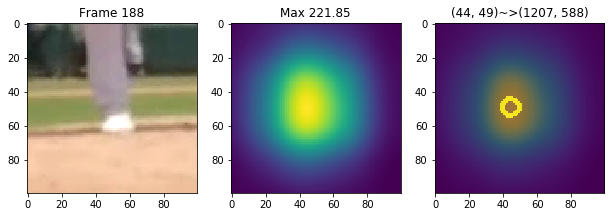

array([1207,  588], dtype=int32)

In [75]:
hmap = np.load('%s/%s' % ('../opp/converted/baseline', folders[REF]))
inspect_region(REF, joints[REF][ANKLE], hmap[ANKLE], frames[REF])

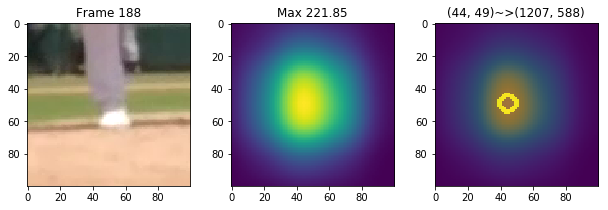

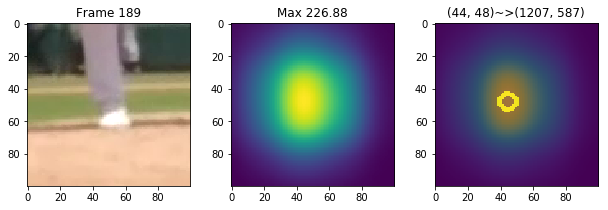

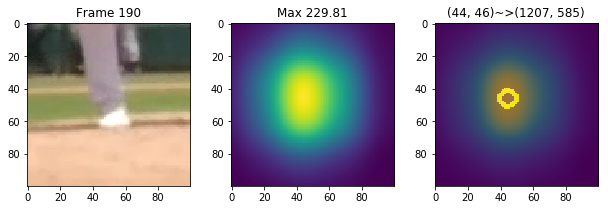

In [76]:
for ii in range(3):
    hmap = np.load('%s/%s' % ('../opp/converted/baseline', folders[REF+ii]))
    inspect_region(REF+ii, joints[REF][ANKLE], hmap[ANKLE], frames[REF+ii], figsize=(14, 3))

### Ankle coordinates vary wildly

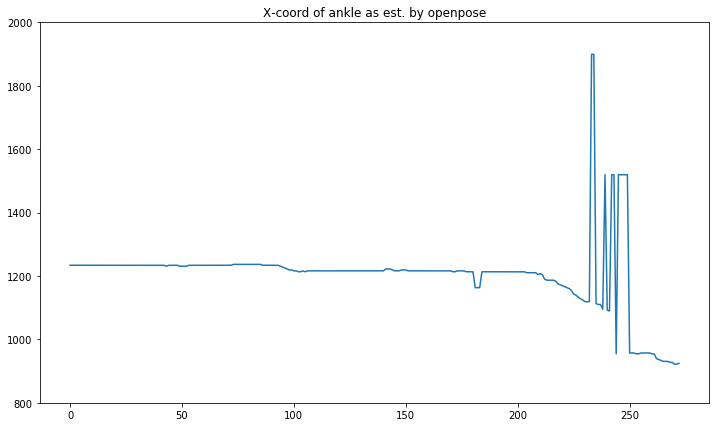

In [12]:
plt.figure(figsize=(12, 7))
plt.ylim(800, 2000)
plt.title('X-coord of ankle as est. by openpose')
ankleX = [frame[ANKLE][0] for frame in joints]
# ankleX = joints[:][ANKLE][0]
# print(ankleX.shape)
plt.plot(ankleX)
plt.show()

### Local maxima tracking

In [ ]:
import numpy.linalg as lin

hist = []
scan_size=50
broken = False
for ii in range(REF, len(frames)):
    current = np.array(joints[ii][ANKLE]).astype(np.int32)
    if broken or len(hist) > 1 and lin.norm(hist[-1] - current) > scan_size/2:
        broken = True
        print('[%d] Jump from %s -> %s' % (ii, hist[-1].tolist(), current.tolist()))
        prev_known = hist[-1]
        current_hmap = np.load('%s/%s' % ('../opp/converted/baseline', folders[ii]))
        local_peak = inspect_region(ii, prev_known, current_hmap[ANKLE], frames[ii], figsize=(14, 3), scan_size=scan_size)
        if local_peak is None:
            print('ERR: Could not find max')
            local_peak = hist[-1]
        print('  Local %s vs Given %s' % (local_peak.tolist(), current.tolist()))
        hist.append(local_peak)
    else:
        hist.append(current)

heat_hist = hist

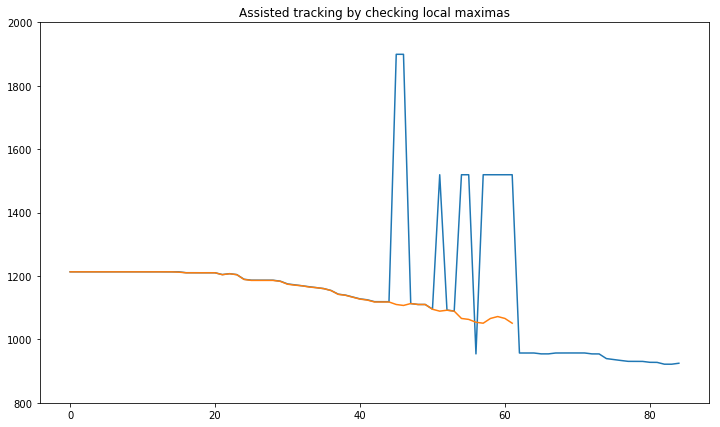

In [34]:
plt.figure(figsize=(12, 7))
plt.ylim(800, 2000)
plt.title('Assisted tracking by checking local maximas')
# ankleX = joints[:][ANKLE][0]
# print(ankleX.shape)
plt.plot(ankleX[REF:])
plt.plot(hist)
plt.show()

### Aux box tracking

In [51]:
def rgb_norm(img1, img2):
    
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    return lin.norm(img1-img2)
#     diffR = (img1[:, :, 0] - img2[:, :, 0])**2
#     diffG = (img1[:, :, 1] - img2[:, :, 1])**2
#     diffB = (img1[:, :, 2] - img2[:, :, 2])**2
#     diff = np.mean([diffR, diffG, diffB])
#     print(diff)
#     return 0

def get_template(center, frames, size=50):
    hf = int(size/2)
    cx, cy = int(center[0]), int(center[1])
#     print(cx, cy)
#     print(frames.shape)
    return frames[cy-hf:cy+hf, cx-hf:cx+hf]

def track_box(fii, scan_center, tbuffer, img, scan_size=100, stride=4, figsize=(14, 5), heatmap=None, plot=True):
    sx, sy = int(scan_center[0]), int(scan_center[1])
    half = int(scan_size/2)
    img_region = img[sy-half:sy+half, sx-half:sx+half]
    min_pos = None
    min_diff = 1000000000
    grade_map = np.zeros(img_region.shape[:2], dtype=np.float32)
    for yy in range(0, scan_size-tbuffer[-1].shape[0], stride):
        for xx in range(0, scan_size-tbuffer[-1].shape[1], stride):
            diff = 0
            for template in tbuffer:
                patch = img_region[yy:yy+template.shape[0], xx:xx+template.shape[1], :]
                diff += rgb_norm(template, patch)
            grade_map[yy:yy+template.shape[0], xx:xx+template.shape[1]] = diff
            if min_pos is None or diff < min_diff:
                min_pos = (xx, yy)
                min_diff = diff
    grade_map /= np.max(grade_map)
    drawn = img_region.copy()
    cv2.rectangle(drawn, min_pos, tuple([pos+template.shape[0] for pos in min_pos]), (255,0,0), 2)
    minX, minY = min_pos
    globalX, globalY = sx-half+minX+int(tbuffer[-1].shape[1]/2), sy-half+minY+int(tbuffer[-1].shape[0]/2)
    
    if not plot:
        return np.array([globalX, globalY])
    
    if plot:
        plt.figure(figsize=figsize)
        plt.subplot(1, 5, 1)
        plt.gca().set_title('Frame %d' % fii)
        plt.imshow(img_region)
        plt.subplot(1, 5, 2)
        plt.gca().set_title('Template %d-way'% len(tbuffer))
    #     plt.gca().set_title('Max %.2f' % np.max(h_region))
        plt.imshow(tbuffer[-1])
        plt.subplot(1, 5, 3)
        plt.gca().set_title('Diff map')
        plt.imshow(grade_map)
        plt.imshow(img_region)
        plt.imshow(grade_map, alpha=0.5, cmap='gnuplot')
        plt.subplot(1, 5, 4)
        plt.gca().set_title('Best match: %s' % (min_pos, ))
        plt.imshow(drawn)
        if heatmap is not None:
            hx, hy = inspect_region(fii, scan_center, heatmap, img, plot=False)
            heatmap = cv2.resize(heatmap, (0,0), fx=img.shape[1]/heatmap.shape[1], fy=img.shape[0]/heatmap.shape[0])
            heat_overlay = np.zeros(heatmap.shape)
            cv2.circle(heat_overlay, (hx, hy), 10, 255, 2)
    #         cv2.circle(overlay, (hx, hy), 10, 255, 2)

            plt.subplot(1, 5, 5)
            plt.gca().set_title('Original Heatmap (%d,%d)' % (hx, hy))
    #         plt.gca().set_title('Best match: %s' % (min_pos, ))

    #         h_region = 
    #         print(heatmap.shape, h_region.shape)
            plt.imshow(heatmap[sy-half:sy+half, sx-half:sx+half])
            plt.imshow(heat_overlay[sy-half:sy+half, sx-half:sx+half], alpha=0.5)
        plt.show()
    return np.array([globalX, globalY])
    
    
#     return np.array([gMaxX, gMaxY]).astype(np.int32)
rgb_norm(np.array([[[1, 2, 3]]]), np.array([[[2, 3, 4]]]))

1.7320508

In some cases, simple template matching can allow easier tracking of joints than inferring from heatmap.

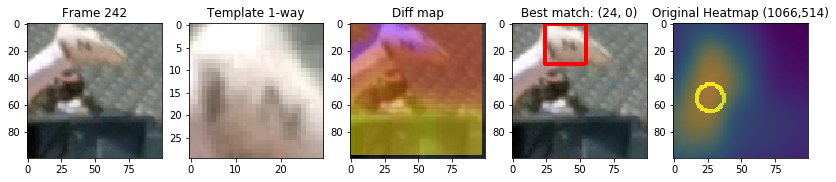

array([1078,  474])

In [52]:

BOXREF = 242

# use t-10th instance as template to match
TEMPLATE_LAG = 5
SCAN_LAG = 1
tmpl = get_template(joints[BOXREF-TEMPLATE_LAG][ANKLE], frames[BOXREF-TEMPLATE_LAG], size=30)  
tbuffer = [tmpl]
# scan around center of previous frame
scan_center = joints[BOXREF-SCAN_LAG][ANKLE] 
scan_in_frame = frames[BOXREF]
current_hmap = np.load('%s/%s' % ('../opp/converted/baseline', folders[BOXREF]))[ANKLE]
track_box(BOXREF, scan_center, tbuffer, scan_in_frame, heatmap=current_hmap)
track_box(BOXREF, scan_center, tbuffer, scan_in_frame, heatmap=current_hmap, plot=False)

[233] Jump from [1118, 547] -> [1898, 603]
 Div:5.39 Heat:[1110, 538] Template:[1115, 540] Given:[1898, 603]


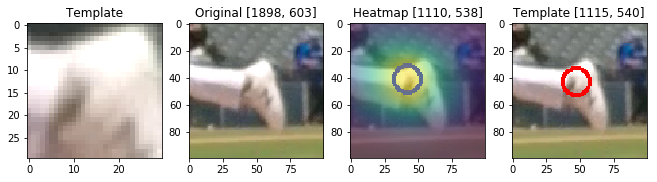

[234] Jump from [1115, 540] -> [1899, 603]
 Div:5.10 Heat:[1107, 532] Template:[1112, 533] Given:[1899, 603]


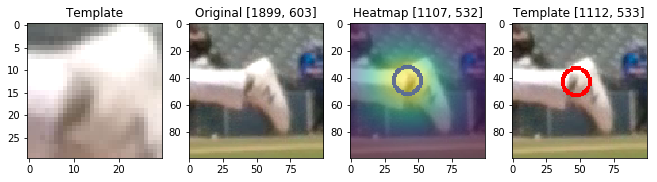

[239] Jump from [1095, 509] -> [1519, 571]
 Div:18.38 Heat:[1089, 511] Template:[1096, 494] Given:[1519, 571]


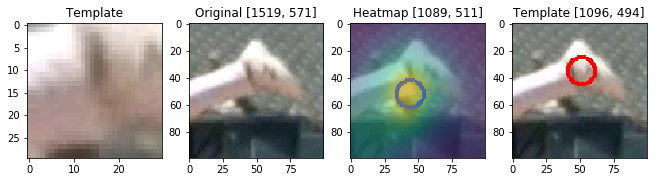

[242] Jump from [1089, 509] -> [1519, 571]
 Div:43.27 Heat:[1066, 514] Template:[1102, 490] Given:[1519, 571]


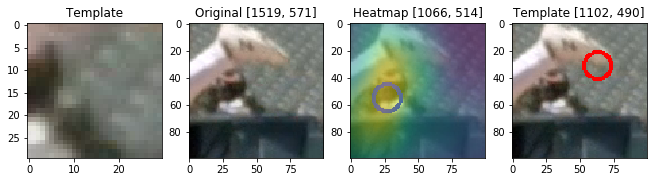

In [66]:
# try:
hist = []
# heat_hist = []
TEMPLATE_LAG = 4
tbuffer = []
templ_hist = []
SCAN_SIZE=100
for ii in range(REF, len(frames)):
    current = np.array(joints[ii][ANKLE]).astype(np.int32)
    if len(hist) > 1 and lin.norm(hist[-1] - current) > 20:
        print('[%d] Jump from %s -> %s' % (ii, hist[-1].tolist(), current.tolist()))
        prev_known = hist[-1]
        current_hmap = np.load('%s/%s' % ('../opp/converted/baseline', folders[ii]))[ANKLE]
        local_peak = inspect_region(ii, prev_known, current_hmap, frames[ii], figsize=(14, 3), plot=False, scan_size=SCAN_SIZE)
        if local_peak is None:
            local_peak = current

        
            
        local_matched = track_box(ii, prev_known, tbuffer, frames[ii], heatmap=current_hmap, plot=False, scan_size=SCAN_SIZE)
        
        ht_diff = lin.norm(local_peak - local_matched)
        
        print(' Div:%.2f Heat:%s Template:%s Given:%s' % (
            ht_diff, local_peak.tolist(), local_matched.tolist(), current.tolist()))
        
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 5, 1)
        plt.gca().set_title('Template')
        plt.imshow(tmpl)
        plt.subplot(1, 5, 2)
        region_img = get_template(hist[-1], frames[ii], size=100)
        sized_heat = cv2.resize(current_hmap, (0,0), fx=frames[ii].shape[1]/current_hmap.shape[1], fy=frames[ii].shape[0]/current_hmap.shape[0])
        region_heat = get_template(hist[-1], sized_heat, size=100)
        plt.gca().set_title('Original %s' % (current.tolist(),))
        plt.imshow(region_img)
        plt.subplot(1, 5, 3)
        plt.gca().set_title('Heatmap %s' % (local_peak.tolist(),))
        marked_img = frames[ii].copy()
        cv2.circle(marked_img, tuple(local_peak.tolist()), 10, (0, 0, 255), 2)
        marked_img = get_template(hist[-1], marked_img, size=100)
        plt.imshow(marked_img)
        plt.imshow(region_heat, alpha=0.5)
        plt.subplot(1, 5, 4)
        plt.gca().set_title('Template %s' % (local_matched.tolist(),))
        marked_img = frames[ii].copy()
        cv2.circle(marked_img, tuple(local_matched.tolist()), 10, (255, 0, 0), 2)
        marked_img = get_template(hist[-1], marked_img, size=100)
        plt.imshow(marked_img)
        plt.show()
#         break

#         if ht_diff > 10:
#             print('Divergeance exceeded: %.2f' % ht_diff)
#             break
        
        hist.append(local_matched)
#         heat_hist.append(local_peak)
        templ_hist.append(local_matched)
        if ii == 242:
            break
    else:
        hist.append(current)
#         heat_hist.append(current)
        templ_hist.append(current)
    
    tmpl = get_template(hist[-1], frames[ii], size=30)
    tbuffer.append(tmpl)
    while len(tbuffer) > TEMPLATE_LAG:
        tbuffer = tbuffer[1:]
# except:
#     print('Error: Lost track of joint...')
    

In [64]:
hist[-4:]

[array([1096,  494]),
 array([1092,  506], dtype=int32),
 array([1089,  509], dtype=int32),
 array([1102,  490])]

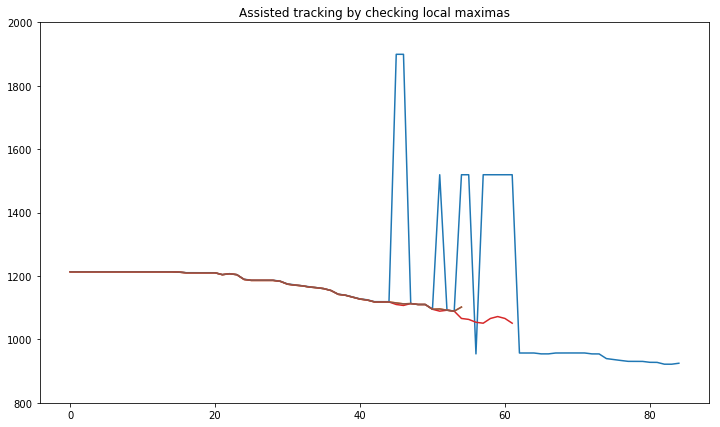

In [63]:
plt.figure(figsize=(12, 7))
plt.ylim(800, 2000)
plt.title('Assisted tracking by checking local maximas')
# ankleX = joints[:][ANKLE][0]
# print(ankleX.shape)
plt.plot(ankleX[REF:])
plt.plot(hist)
plt.plot(heat_hist)
plt.plot(templ_hist)
plt.show()